In [499]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import cross_val_score
import numpy as np

# Read Datasets

In [500]:
df_benign = pd.read_csv('dataset/benign_final.csv')
df_botnet = pd.read_csv('dataset/botnet_final.csv')#.rename(columns={'Protocol':'protocol'})
df_portscan = pd.read_csv('dataset/port_scan_final.csv')#.rename(columns={'Protocol':'protocol'})
df_ddos = pd.read_csv('dataset/ddos_final.csv')#.rename(columns={'Protocol':'protocol'})

In [501]:
df = pd.concat([df_benign, df_botnet, df_portscan, df_ddos], axis=0)
# Remove Empty FLOW IDS
mask = ~df[['sport', 'src_ip', 'dst_port', 'dst_ip']].isnull().any(axis=1)

# Apply the mask to filter rows
df = df[mask]

- Flow id need to be unique. WHY IT ISN'T?

In [502]:
# Create Flow ID Column
df['sport'] = df['sport'].astype(int).astype(str)
df['dst_port'] = df['sport'].astype(int).astype(str)
df['flow_id'] = df['src_ip'] + '-' + df['dst_ip'] + '-' + df['sport'] + '-' + df['dst_port']

In [503]:
df['flow_id'].value_counts()

172.16.0.1-192.168.10.50-37255-37255        124
172.16.0.1-192.168.10.50-56383-56383        114
172.16.0.1-192.168.10.50-62223-62223        112
172.16.0.1-192.168.10.50-35613-35613        112
172.16.0.1-192.168.10.50-42849-42849        112
                                           ... 
192.168.10.5-205.174.165.73-52003-52003       1
192.168.10.9-205.174.165.73-6404-6404         1
192.168.10.15-205.174.165.73-53853-53853      1
192.168.10.8-205.174.165.73-4760-4760         1
172.16.0.1-192.168.10.50-65146-65146          1
Name: flow_id, Length: 19766, dtype: int64

- Handling NaNs

In [504]:
df.isnull().sum()

sport                         0
src_ip                        0
dst_port                      0
dst_ip                        0
protocol                      0
first_timestamp               0
last_timestamp                0
flow_duration                 0
total_size                    0
avg_size                      0
std_size                      0
inter_arrival_mean           32
inter_arrival_std            32
total_fwd_packets             0
first_timestamp_fwd           0
last_timestamp_fwd            0
fwd_flow_duration             0
total_fwd_pkt_size            0
avg_fwd_pkt_size              0
std_fwd_pkt_size              0
inter_arrival_mean_fwd    17543
inter_arrival_std_fwd     17543
total_bwd_packets             0
first_timestamp_bwd          43
last_timestamp_bwd           43
bwd_flow_duration            43
total_bwd_pkt_size            0
avg_bwd_pkt_size             43
std_bwd_pkt_size             43
inter_arrival_mean_bwd    17802
inter_arrival_std_bwd     17802
syn_flag

In [505]:
# Get only the numeric columns
numeric_cols = df.select_dtypes(include=['number'])

# Fill NaN values with the mean of each numeric column
df[numeric_cols.columns] = numeric_cols.fillna(numeric_cols.mean())

- Convert datetime features -> get the Unix timestamp.

In [506]:
df['first_timestamp'] = pd.to_datetime(df['first_timestamp']).astype(int) / 10**9
df['first_timestamp_fwd'] = pd.to_datetime(df['first_timestamp_fwd']).astype(int) / 10**9


df['last_timestamp_bwd'] = pd.to_datetime(df['last_timestamp_bwd']).astype(int) / 10**9

df['last_timestamp'] = pd.to_datetime(df['last_timestamp']).astype(int) / 10**9

df['first_timestamp_bwd'] = pd.to_datetime(df['first_timestamp_bwd']).astype(int) / 10**9

df['last_timestamp_fwd'] = pd.to_datetime(df['last_timestamp_fwd']).astype(int) / 10**9


# Dataframe - Rescaled Proportions

In [507]:
original_total = 2187304

In [508]:
benign = 1807787
ddos = 320269
portscan = 57305
botnet = 1943

In [509]:
print('Benign %: ', benign/original_total)
print('Ddos %: ', ddos/original_total)
print('PortScan %: ', portscan/original_total)
print('Botnet %: ', botnet/original_total)

Benign %:  0.8264909678764361
Ddos %:  0.14642180510802338
PortScan %:  0.02619891885170054
Botnet %:  0.0008883081638400515


In [510]:
benign_count = df['label'].value_counts().benign
ddos_count = int(np.floor(df['label'].value_counts().benign*ddos/original_total))
portscan_count = int(np.floor(df['label'].value_counts().benign*portscan/original_total))
botnet_count = int(np.floor(df['label'].value_counts().benign*botnet/original_total))

In [511]:
df_resampled = pd.concat([
    df[df['label'] == 'benign'],
    df[df['label'] == 'ddos'].sample(ddos_count, random_state=42),
    df[df['label'] == 'port_scan'].sample(portscan_count, random_state=42),
    df[df['label'] == 'botnet'].sample(botnet_count, random_state=42)
])

In [512]:
print(df_resampled['label'].value_counts())
# Compute proportions
proportions = df_resampled['label'].value_counts()*100 / len(df_resampled)

# Display proportions
print(proportions)

benign       4802
ddos          703
port_scan     125
botnet          4
Name: label, dtype: int64
benign       85.232517
ddos         12.477813
port_scan     2.218672
botnet        0.070998
Name: label, dtype: float64


# Split dataset

In [513]:
# df = df_resampled

In [514]:
# Removing non-numerical features
features = list(set(df.columns) -\
    set(['label', 'flow_id', 'src_ip', 'dst_port', 'dst_ip', 'sport', 'pkt_lens', 'fwd_inter_arrival_times', 'fwd_arrival_times',
         'bwd_arrival_times', 'arrival_times', 'bwd_pkt_lens', 'inter_arrival_times', 'fwd_pkt_lens', 'bwd_inter_arrival_times']) -\
              set(['first_timestamp', 'last_timestamp', 'first_timestamp_fwd', 'last_timestamp_fwd', 'first_timestamp_bwd', 'last_timestamp_bwd']))
label = ['label']

In [515]:
# # COLUMN len_per_sec has INF

# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df['len_per_sec'].fillna(df['len_per_sec'].mean(), inplace=True)

In [516]:
from sklearn.model_selection import train_test_split


X = df[features]
# X = df[['flow_duration', 'inter_arrival_std_bwd']]
y = df[label]


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Binarize the labels
y_bin = label_binarize(y_encoded, classes=[0, 1, 2, 3])

/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Box plots analysis

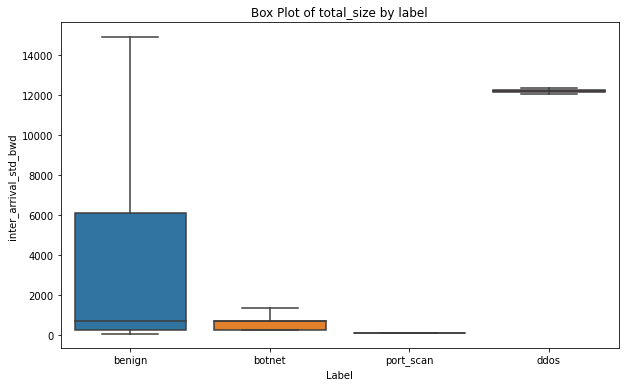

In [517]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='total_size', data=df, showfliers=False)
plt.title('Box Plot of total_size by label')
plt.xlabel('Label')
plt.ylabel('inter_arrival_std_bwd')
plt.show()

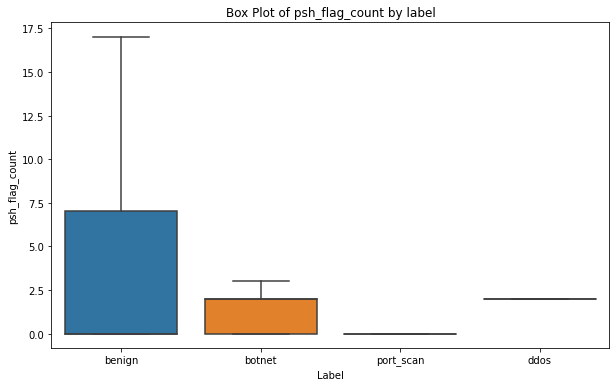

In [518]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='psh_flag_count', data=df, showfliers=False)
plt.title('Box Plot of psh_flag_count by label')
plt.xlabel('Label')
plt.ylabel('psh_flag_count')
plt.show()

# Model

In [519]:
pd.set_option('display.max_columns', None)

In [520]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from itertools import cycle

- Logistic Regression

In [521]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=42)

In [522]:
# Create the classifier
clf = OneVsRestClassifier(Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(max_iter=10000))]))

In [523]:
# Train the classifier
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('classifier',
                                               LogisticRegression(max_iter=10000))]))

In [524]:
y_score = clf.predict_proba(X_test)

In [525]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

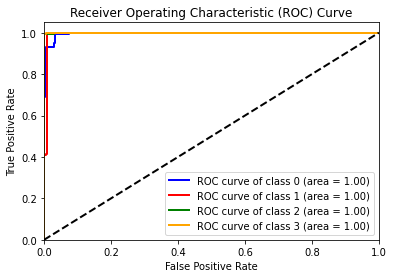

In [526]:
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [527]:
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.98 accuracy with a standard deviation of 0.01


- XGB

In [528]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [529]:
y_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

In [530]:
# Initialize XGBoost classifier for multiclass classification
xgb_clf = XGBClassifier(
    n_estimators=10,
    max_depth=3,
    objective='multi:softmax', num_class=len(y['label'].unique()))

In [531]:
# Train the classifier
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_class=4, num_parallel_tree=None,
              objective='multi:softmax', ...)

In [532]:
# Predict on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_prob = xgb_clf.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1445
           1       0.98      1.00      0.99       360
           2       1.00      1.00      1.00      2572
           3       1.00      1.00      1.00      4834

    accuracy                           1.00      9211
   macro avg       0.99      1.00      1.00      9211
weighted avg       1.00      1.00      1.00      9211



In [533]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

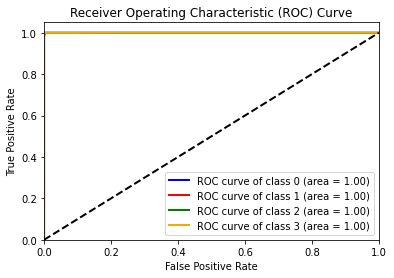

In [534]:
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

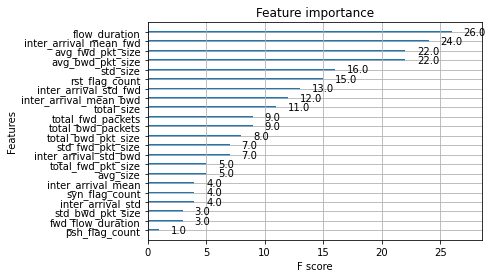

In [535]:
# Plot feature importance
xgb.plot_importance(xgb_clf)
plt.show()

In [536]:
scores = cross_val_score(xgb_clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

1.00 accuracy with a standard deviation of 0.00


In [537]:
# Get unique elements and their counts
unique_elements, counts = np.unique(y_test, return_counts=True)

# Zip them together for readability
element_counts = dict(zip(unique_elements, counts))

# Print the counts
print("Element Counts:")
for element, count in element_counts.items():
    print(f"{element}: {count}")

Element Counts:
0: 1445
1: 360
2: 2572
3: 4834


In [538]:
# Get unique elements and their counts
unique_elements, counts = np.unique(y_pred, return_counts=True)

# Zip them together for readability
element_counts = dict(zip(unique_elements, counts))

# Print the counts
print("Element Counts:")
for element, count in element_counts.items():
    print(f"{element}: {count}")

Element Counts:
0: 1442
1: 366
2: 2575
3: 4828


In [539]:
# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9980458147866681


- RF

In [540]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [541]:
feature_names = list(X_train.columns)

In [542]:
y_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

In [543]:
# Initialize Random Forest classifier for multiclass classification
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [544]:
# Train the classifier
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)

y_pred_prob = rf_clf.predict_proba(X_test)

In [545]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1445
           1       1.00      1.00      1.00       360
           2       1.00      1.00      1.00      2572
           3       1.00      1.00      1.00      4834

    accuracy                           1.00      9211
   macro avg       1.00      1.00      1.00      9211
weighted avg       1.00      1.00      1.00      9211

Accuracy: 1.0


In [546]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

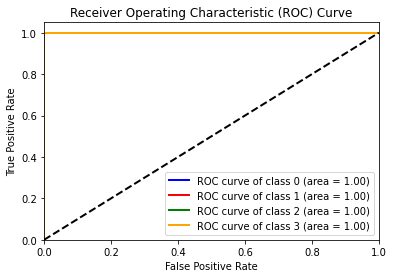

In [547]:
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

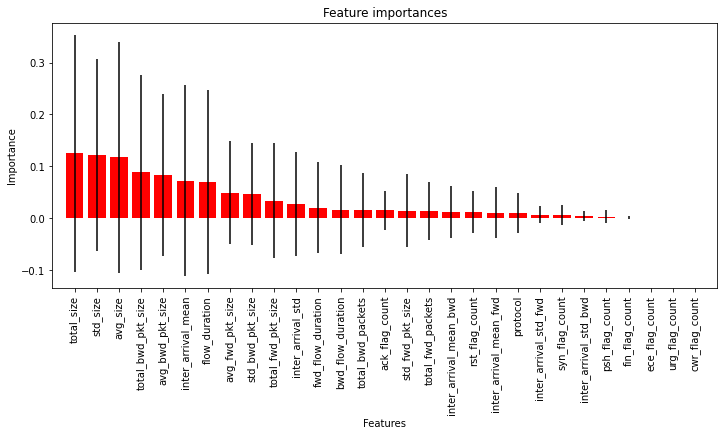

In [548]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)  # Replace with original feature names and rotate x-axis labels by 45 degrees
plt.xlim([-1, X.shape[1]])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout(pad=0.5)
plt.show()

In [549]:
scores = cross_val_score(rf_clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

1.00 accuracy with a standard deviation of 0.00
